# 1. Import and Install Dependencies

## 1.1 Install Dependencies

In [ ]:
# !pip install tensorflow tensorflow-io[tensorflow]

## 1.2 Load Dependencies

In [ ]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

# 2. Build Data Loading Function

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2.1 Define Paths to Files

In [ ]:
CAPUCHIN_FILE = os.path.join('/content/drive/MyDrive/Colab Notebooks/Projects/Audio_files', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('/content/drive/MyDrive/Colab Notebooks/Projects/Audio_files', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [ ]:
import tensorflow as tf
import tensorflow_io as tfio

# Verify TensorFlow-IO installation
try:
    test_audio = tf.random.uniform([44100], dtype=tf.float32)
    test_resample = tfio.audio.resample(test_audio, rate_in=44100, rate_out=16000)
    print("TensorFlow-IO is working correctly.")
except NotImplementedError as e:
    print(f"TensorFlow-IO error: {e}")

TensorFlow-IO is working correctly.


## 2.2 Build Dataloading Function

In [ ]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## 2.3 Plot Wave

In [ ]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)
nwave.shape

TensorShape([48927])

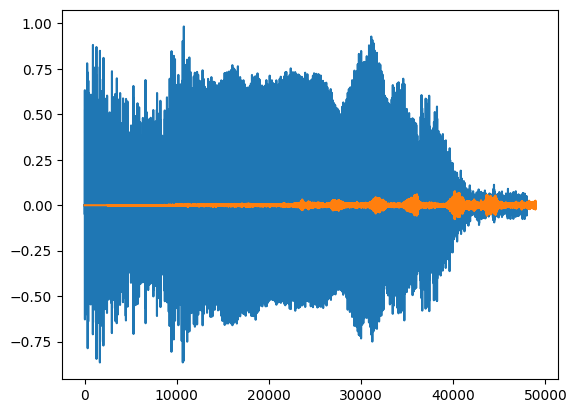

In [ ]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [ ]:
POS = os.path.join('/content/drive/MyDrive/Colab Notebooks/Projects/Audio_files', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('/content/drive/MyDrive/Colab Notebooks/Projects/Audio_files', 'Parsed_Not_Capuchinbird_Clips')

# Verify the paths and files
print("Positive files:", os.listdir(POS))
print("Negative files:", os.listdir(NEG))

Positive files: ['XC114131-1.wav', 'XC114131-0.wav', 'XC114131-2.wav', 'XC114131-3.wav', 'XC114132-0.wav', 'XC114132-2.wav', 'XC114131-4.wav', 'XC114132-1.wav', 'XC114132-3.wav', 'XC114132-4.wav', 'XC119294-0.wav', 'XC114132-5.wav', 'XC16803-1.wav', 'XC16803-0.wav', 'XC114132-6.wav', 'XC178167-0.wav', 'XC168899-0.wav', 'XC16804-1.wav', 'XC16803-2.wav', 'XC16804-0.wav', 'XC178167-1.wav', 'XC178167-3.wav', 'XC178168-2.wav', 'XC178168-0.wav', 'XC178167-2.wav', 'XC178168-3.wav', 'XC178168-1.wav', 'XC201990-1.wav', 'XC178168-5.wav', 'XC201990-2.wav', 'XC178168-6.wav', 'XC201990-5.wav', 'XC201990-4.wav', 'XC216010-1.wav', 'XC178168-7.wav', 'XC201990-0.wav', 'XC216010-2.wav', 'XC216010-0.wav', 'XC201990-3.wav', 'XC178168-4.wav', 'XC216012-12.wav', 'XC216010-4.wav', 'XC216010-5.wav', 'XC216010-3.wav', 'XC216012-10.wav', 'XC216010-6.wav', 'XC216012-1.wav', 'XC216012-0.wav', 'XC216012-11.wav', 'XC216010-7.wav', 'XC216012-15.wav', 'XC216012-14.wav', 'XC216012-18.wav', 'XC216012-13.wav', 'XC216012

## 3.2 Create Tensorflow Datasets

In [ ]:
pos = tf.data.Dataset.list_files(str(POS) + '/*.wav')
neg = tf.data.Dataset.list_files(str(NEG) +'/*.wav')

In [ ]:
len(neg)

593

## 3.3 Add labels and Combine Positive and Negative Samples

In [ ]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)
print(data.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))


In [ ]:
data.shuffle(10000).as_numpy_iterator().next()

(b'/content/drive/MyDrive/Colab Notebooks/Projects/Audio_files/Parsed_Not_Capuchinbird_Clips/crickets-sound-effect-7.wav',
 0.0)

# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [ ]:
lengths = []
for file in os.listdir(os.path.join('/content/drive/MyDrive/Colab Notebooks/Projects/Audio_files', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('/content/drive/MyDrive/Colab Notebooks/Projects/Audio_files', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [ ]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [ ]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [ ]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [ ]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    # print(wav.shape)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    # print("hello this is",tf.shape(wav))
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    # print("hello this is",spectrogram.shape)
    spectrogram = tf.abs(spectrogram)
    # print("hello this is",spectrogram.shape)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    # print("hello this is",spectrogram.shape)
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [ ]:
filepath, label = positives.shuffle(buffer_size = 10000).as_numpy_iterator().next()

In [ ]:
spectrogram, label = preprocess(filepath, label)

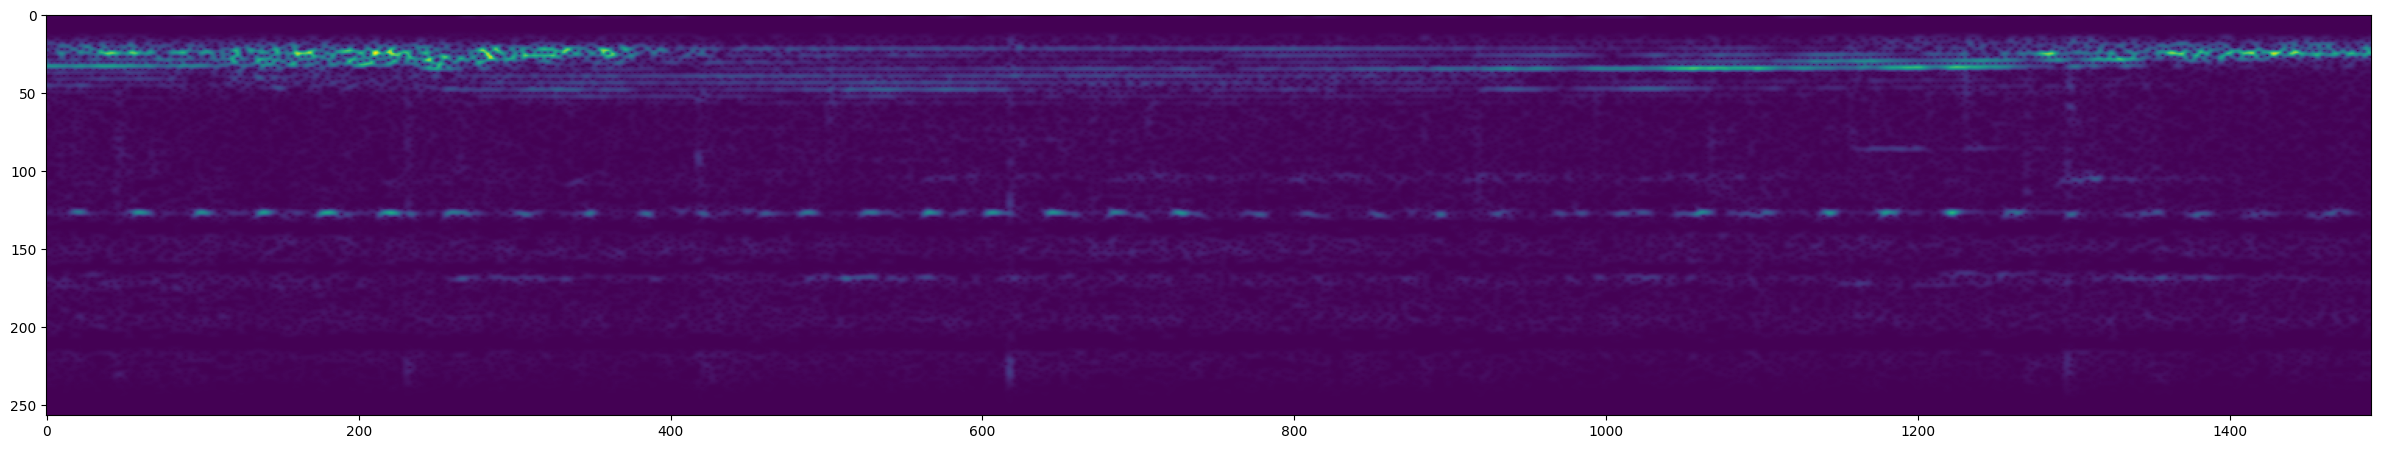

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [ ]:
print(data)
print(data.as_numpy_iterator().next())

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>
(b'/content/drive/MyDrive/Colab Notebooks/Projects/Audio_files/Parsed_Capuchinbird_Clips/XC395129-0.wav', 1.0)


In [ ]:
processed_data_list = []

# Iterate over the dataset and apply preprocess function
for file_path, label in data:
    processed_data, label = preprocess(file_path, label)
    processed_data_list.append((processed_data, label))

In [ ]:
data_1  = tf.data.experimental.from_list(processed_data_list)

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [ ]:
# data_1 = data.map(preprocess)
# print(data_1.element_spec)

In [ ]:
data_2 = data_1.cache()
data_2 = data_2.shuffle(buffer_size=1000)
data_2 = data_2.batch(16)
data_2 = data_2.prefetch(8)

## 6.2 Split into Training and Testing Partitions

In [ ]:
train = data_2.take(36)
# print(train.as_numpy_iterator())
test = data_2.skip(36).take(15)

# train = tf.data.Dataset.from_tensor_slices(train)
# test = tf.data.Dataset.from_tensor_slices(test)

# # for batch in train.take(2):
# #     print(batch)  # This should print (batch_size, 1491, 257, 1)
# # type(train)

## 6.3 Test One Batch

In [ ]:
samples, labels = train.as_numpy_iterator().next()

In [ ]:
samples.shape

(16, 1491, 257, 1)

In [ ]:
labels.shape

(16,)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

## 7.2 Build Sequential Model, Compile and View Summary

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 1489, 255, 16)       │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 1487, 253, 16)       │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6019376)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │     770,480,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 770,482,865 (2.87 GB)

 Trainable params: 770,482,865 (2.87 GB)

 Non-trainable params: 0 (0.00 B)

## 7.3 Fit Model, View Loss and KPI Plots

In [ ]:
hist = model.fit(train, epochs=1, validation_data=test, verbose = 1)

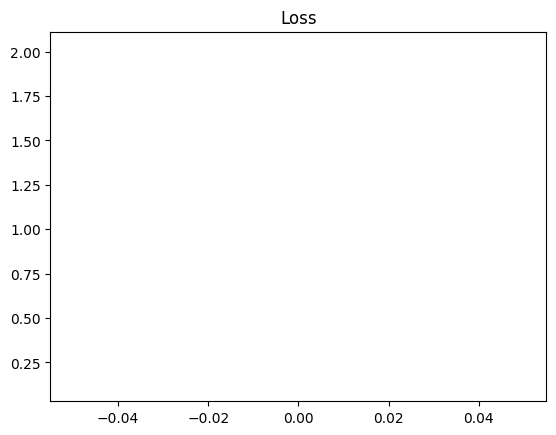

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

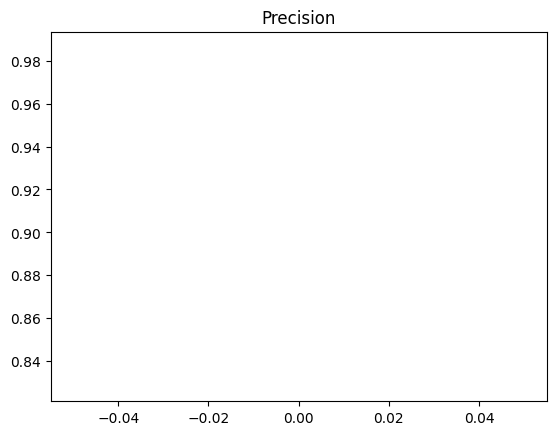

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision_1'], 'r')
plt.plot(hist.history['val_precision_1'], 'b')
plt.show()

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(X_test)

## 8.2 Convert Logits to Classes

In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

## 9.4 Group Consecutive Detections

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [ ]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

In [ ]:
results

## 10.2 Convert Predictions into Classes

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

## 10.3 Group Consecutive Detections

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

# 11. Export Results

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])